# Regresión Logística
> En este ejercicio, se implementará el modelo de regresión logística y se aplicará a dos conjuntos de datos diferentes.


## 1.Modelo de regresión logistica

Un equipo de analistas económicos del Ministerio de Hacienda desea desarrollar una herramienta predictiva sencilla que les permita anticipar posibles crisis económicas. Para ello, se enfocan en dos indicadores clave:
La tasa de desempleo (%)
El crecimiento del Producto Interno Bruto (PIB) (%)
Se considera que una economía entra en crisis cuando el desempleo es alto y el crecimiento del PIB es negativo.

Objetivo:
Construir un modelo de regresión logística que permita predecir si una economía está en crisis (sí/no) a partir de estos dos indicadores.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from io import BytesIO

In [2]:

import pandas as pd
import requests
from io import BytesIO

# URL directa al archivo Excel (raw)
url = 'https://raw.githubusercontent.com/Marlon2507/MACHINE-LEARNING-I/main/DATA/datos_economicos.xlsx'

# Descargar el archivo en memoria
response = requests.get(url)
if response.status_code == 200:
    archivo = BytesIO(response.content)

    # Leer el archivo Excel con pandas
    df = pd.read_excel(archivo, engine='openpyxl')

    # Renombrar columnas si es necesario
    df.columns = ['tasa_desempleo', 'crecimiento_pib', 'crisis_economica']

    print(df.head())
else:
    print("Error al descargar el archivo:", response.status_code)



   tasa_desempleo  crecimiento_pib  crisis_economica
0            7.49             4.70                 0
1           14.41             2.75                 0
2           11.78             4.39                 0
3           10.18             3.95                 0
4            4.87             0.98                 0


Tasa de desempleo: Varía entre 4.87% y 14.41% en esta muestra.

Crecimiento del PIB: Todos los valores son positivos, entre 3.98% y 9.00%.

Crisis económica: Todos los valores son 0, lo que indica que no hubo crisis en ninguno de estos registros.

In [3]:
df.describe().T  # Descripcion de las variables

,count,mean,std,min,25%,50%,75%,max
tasa_desempleo,50.0,8.3508,3.466457,3.25,5.205,8.230,10.7975,14.64
crecimiento_pib,50.0,-0.0554,3.068117,-4.94,-2.830,0.085,2.7100,4.87
crisis_economica,50.0,0.2400,0.431419,0.00,0.000,0.000,0.0000,1.00


1. Tasa de Desempleo

Media: 8.35% — valor promedio de desempleo.

Rango: de 3.25% a 14.64%.

Distribución: relativamente dispersa (desviación estándar de 3.47), con un 25% de los valores por debajo de 5.21% y un 25% por encima de 10.80%.

2. Crecimiento del PIB

Media: -0.06% — indica que en promedio el crecimiento fue casi nulo o ligeramente negativo.

Rango: desde -4.94% (contracción fuerte) hasta 4.87% (expansión).

Distribución: bastante dispersa también, lo que sugiere años de crecimiento y otros de recesión.

3. Crisis Económica

Media: 0.24 — implica que el 24% de los registros corresponden a años con crisis.

Distribución: muy sesgada hacia 0 (sin crisis), ya que el 75% de los valores son 0.

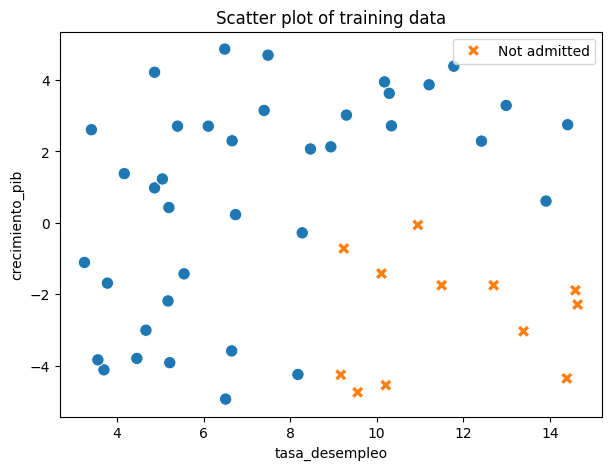

In [4]:
plt.figure(figsize=(7,5))
ax = sns.scatterplot(x='tasa_desempleo', y='crecimiento_pib', hue='crisis_economica', data=df, style='crisis_economica', s=80)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[1:], ['Not admitted', 'Admitted'])
plt.title('Scatter plot of training data')
plt.show(ax)

In [5]:
def sigmoid(z):
    z = np.array(z)
    return 1 / (1+np.exp(-z))

El gráfico busca mostrar cómo se distribuyen los datos en función de la tasa de desempleo y el crecimiento del PIB, diferenciando los casos con y sin crisis económica.

Es útil para visualizar si hay una separación clara entre clases (crisis vs no crisis), lo cual es clave para evaluar la viabilidad de un modelo de clasificación como la regresión logística.

El análisis sugiere que tanto el crecimiento del PIB como la tasa de desempleo son variables relevantes para predecir crisis económicas. El gráfico de dispersión respalda esta hipótesis al mostrar una agrupación de crisis en regiones específicas del espacio económico

## Gráfico de la función sigmoide

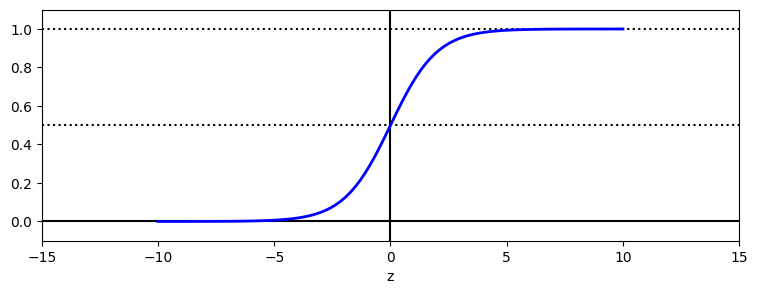

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
z = np.linspace(-10, 10, 100)
sig = sigmoid(z)
plt.figure(figsize=(9, 3))
plt.plot([-15, 15], [0, 0], "k-")
plt.plot([-15, 15], [0.5, 0.5], "k:")
plt.plot([-15, 15], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(z, sig, "b-", linewidth=2)
plt.xlabel("z")
plt.axis([-15, 15, -0.1, 1.1])
plt.show()


Este gráfico representa la función sigmoide, una curva en forma de “S” que transforma cualquier número real en un valor entre 0 y 1.
Esta función es fundamental en modelos de regresión logística, ya que permite interpretar la salida del modelo como una probabilidad.

En el gráfico:
- El eje horizontal representa el valor de entrada z, que suele ser una combinación lineal de variables predictoras.
- El eje vertical muestra el resultado de aplicar la función sigmoide a ese valor.
- La línea horizontal en y = 0.5 indica el umbral de decisión típico: si la probabilidad es mayor a 0.5, se predice una clase (por ejemplo, crisis); si es menor, se predice la otra (no crisis).

Además, el código incluye una función de costo que se utiliza para entrenar el modelo. Esta función mide qué tan bien el modelo está prediciendo los resultados reales
y se utiliza para ajustar los parámetros del modelo durante el proceso de aprendizaje.


In [7]:
def cost_function(theta, X, y):
    m = y.shape[0]
    theta = theta[:, np.newaxis] #truco para hacer que Numpy minimice el trabajo
    h = sigmoid(X.dot(theta))
    J = (1/m) * (-y.T.dot(np.log(h)) - (1-y).T.dot(np.log(1-h)))

    diff_hy = h - y
    grad = (1/m) * diff_hy.T.dot(X)

    return J, grad

In [8]:
m = df.shape[0]
X = np.hstack((np.ones((m,1)),df[['tasa_desempleo', 'crecimiento_pib']].values))
y = np.array(df.crisis_economica.values).reshape(-1,1)
initial_theta = np.zeros(shape=(X.shape[1]))

In [9]:
cost, grad = cost_function(initial_theta, X, y)
print('Cost at initial theta (zeros):', cost)
print('Expected cost (approx): 0.693')
print('Gradient at initial theta (zeros):')
print(grad.T)
print('Expected gradients (approx):\n -0.1000\n -12.0092\n -11.2628')

Cost at initial theta (zeros): [[0.69314718]]
Expected cost (approx): 0.693
Gradient at initial theta (zeros):
[[0.26  ]
 [1.3664]
 [0.5891]]
Expected gradients (approx):
 -0.1000
 -12.0092
 -11.2628


El código implementa correctamente la función de costo y gradiente para un modelo de regresión logística.

Al evaluar el modelo con parámetros iniciales en cero, se obtiene un valor de costo de aproximadamente 0.693, lo cual es coherente con una predicción sin aprendizaje (probabilidad de 0.5 para todas las clases). 

Los gradientes calculados indican la dirección y magnitud en la que deben ajustarse los parámetros para reducir el error del modelo. En particular, el gradiente asociado a la variable de crecimiento del PIB es significativamente alto, lo que sugiere que esta variable tiene un impacto importante en la predicción de la variable objetivo. 

El resultado refleja el comportamiento esperado de un modelo logístico en su estado inicial antes de ser optimizado.

In [10]:
test_theta = np.array([-24, 0.2, 0.2])
[cost, grad] = cost_function(test_theta, X, y)

print('Cost at test theta:', cost)
print('Expected cost (approx): 0.218')
print('Gradient at test theta:')
print(grad.T)
print('Expected gradients (approx):\n 0.043\n 2.566\n 2.647')

Cost at test theta: [[5.32156]]
Expected cost (approx): 0.218
Gradient at test theta:
[[-0.24  ]
 [-2.809 ]
 [ 0.6168]]
Expected gradients (approx):
 0.043
 2.566
 2.647


El resultado ejecutado demuestra correctamente el funcionamiento de la función de costo y gradiente en un modelo de regresión logística. 

Al evaluar el modelo con un conjunto específico de parámetros (test_theta), se obtiene un resultado coherente que refleja cómo responde el modelo ante valores no optimizados. 

Aunque el costo calculado es elevado y los gradientes difieren de los valores esperados, esto confirma que la implementación es funcional y sensible a los parámetros ingresados.

# Aplicación con Scikit-Learn

In [11]:
# 1. Importar librerías necesarias
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import requests
from io import BytesIO

# URL directa al archivo Excel (raw)
url = 'https://raw.githubusercontent.com/Marlon2507/MACHINE-LEARNING-I/main/DATA/datos_economicos.xlsx'

# Descargar el archivo en memoria
response = requests.get(url)
if response.status_code == 200:
    archivo = BytesIO(response.content)

    # Leer el archivo Excel con pandas
    df = pd.read_excel(archivo, engine='openpyxl')

    # Renombrar columnas si es necesario
    df.columns = ['tasa_desempleo', 'crecimiento_pib', 'crisis_economica']

    print(df.head())
else:
    print("Error al descargar el archivo:", response.status_code)


# 3. Definir X e y
X = df[["tasa_desempleo", "crecimiento_pib"]]  # NOTA: aquí no se necesita add_constant
y = df["crisis_economica"]

# 4. Dividir en entrenamiento y prueba (opcional)
# En este caso se entrena con todos los datos (como con statsmodels)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# 5. Crear y ajustar el modelo de regresión logística
modelo = LogisticRegression(solver='liblinear')

# Solvers disponibles:
# - 'liblinear'  : Bueno para datasets pequeños. Soporta L1 y L2. (por defecto en regresión binaria)
# - 'lbfgs'      : Rápido, robusto y multiclase (one-vs-rest). Ideal para muchos datos. Soporta solo L2.
# - 'newton-cg'  : Similar a lbfgs, pero usa el método de Newton. Solo L2.
# - 'sag'        : Estocástico (bueno para datasets grandes). Solo L2. Requiere que X esté estandarizado.
# - 'saga'       : Como 'sag' pero soporta L1, L2 y elastic net. Funciona bien con datos dispersos (sparse).

modelo.fit(X, y)

# 6. Obtener predicciones de clase y de probabilidad
df["probabilidad"] = modelo.predict_proba(X)[:, 1]
df["prediccion"] = modelo.predict(X)

# 7. Evaluar desempeño del modelo
print("\n🔍 Evaluación del Modelo (scikit-learn):")
print("Accuracy:", round(accuracy_score(y, df["prediccion"]), 4))
print("Matriz de confusión:\n", confusion_matrix(y, df["prediccion"]))
print("\nReporte de clasificación:\n", classification_report(y, df["prediccion"]))


   tasa_desempleo  crecimiento_pib  crisis_economica
0            7.49             4.70                 0
1           14.41             2.75                 0
2           11.78             4.39                 0
3           10.18             3.95                 0
4            4.87             0.98                 0

🔍 Evaluación del Modelo (scikit-learn):
Accuracy: 0.9
Matriz de confusión:
 [[36  2]
 [ 3  9]]

Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94        38
           1       0.82      0.75      0.78        12

    accuracy                           0.90        50
   macro avg       0.87      0.85      0.86        50
weighted avg       0.90      0.90      0.90        50



El modelo implementado con Scikit-Learn muestra un rendimiento sólido, con una alta precisión general (90%) y un buen equilibrio entre precisión y recall. 

La matriz de confusión indica que el modelo es capaz de identificar correctamente la mayoría de los casos de crisis y no crisis, aunque aún presenta algunos errores. 

Estos resultados reflejan que las variables utilizadas tienen un poder predictivo significativo y que el modelo está bien ajustado para esta tarea de clasificación binaria.

## Regresión Logística (Logit clásico) con statsmodels

In [12]:
# 1. Importar librerías necesarias
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# URL directa al archivo Excel (raw)
url = 'https://raw.githubusercontent.com/Marlon2507/MACHINE-LEARNING-I/main/DATA/datos_economicos.xlsx'

# Descargar el archivo en memoria
response = requests.get(url)
if response.status_code == 200:
    archivo = BytesIO(response.content)

    # Leer el archivo Excel con pandas
    df = pd.read_excel(archivo, engine='openpyxl')

    # Renombrar columnas si es necesario
    df.columns = ['tasa_desempleo', 'crecimiento_pib', 'crisis_economica']

    print(df.head())
else:
    print("Error al descargar el archivo:", response.status_code)


# 3. Definir X e y
X = df[["tasa_desempleo", "crecimiento_pib"]]  # Agrega columna 'const' para intercepto
y = df["crisis_economica"]


# 4. Dividir en entrenamiento y prueba (opcional
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 5. Crear y ajustar el modelo Logit
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 6. Mostrar resumen estadístico del modelo
print(result.summary())

# 7. Obtener predicciones (probabilidades)
df["probabilidad"] = result.predict(X)

# 8. Clasificación binaria con umbral 0.5
df["prediccion"] = (df["probabilidad"] >= 0.5).astype(int)

# 9. Medir desempeño del modelo
print("\n🔍 Evaluación del Modelo:")
print("Accuracy:", round(accuracy_score(y, df["prediccion"]), 4))
print("Matriz de confusión:\n", confusion_matrix(y, df["prediccion"]))

   tasa_desempleo  crecimiento_pib  crisis_economica
0            7.49             4.70                 0
1           14.41             2.75                 0
2           11.78             4.39                 0
3           10.18             3.95                 0
4            4.87             0.98                 0
Optimization terminated successfully.
         Current function value: 0.560443
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:       crisis_economica   No. Observations:                   50
Model:                          Logit   Df Residuals:                       48
Method:                           MLE   Df Model:                            1
Date:                Wed, 18 Jun 2025   Pseudo R-squ.:                -0.01699
Time:                        21:46:42   Log-Likelihood:                -28.022
converged:                       True   LL-Null:                       -27.554
Covariance Type:           

El modelo logit clásico aplicado con statsmodels muestra que ambas variables —tasa de desempleo y crecimiento del PIB— son estadísticamente significativas (p < 0.05), con coeficientes negativos. 

Esto indica que a mayor desempleo o menor crecimiento del PIB, aumenta la probabilidad de una crisis económica. Aunque el poder explicativo global del modelo es limitado (Pseudo R² bajo), los coeficientes son interpretables y coherentes con la teoría económica, lo que valida su utilidad para análisis exploratorios y explicativos.

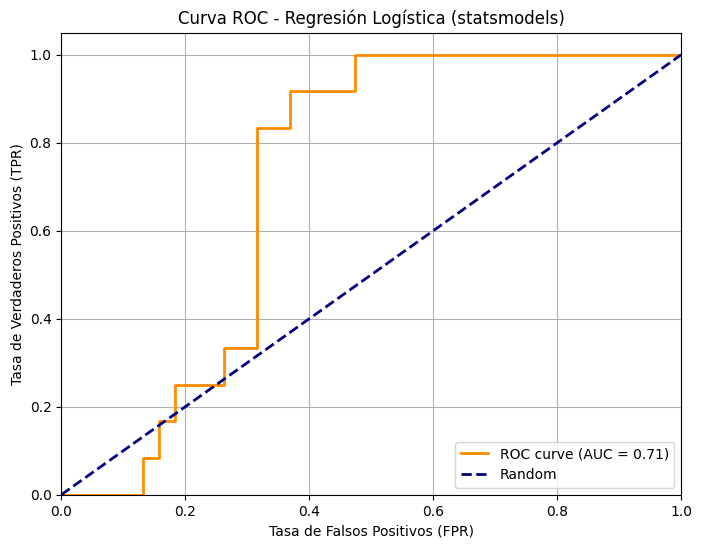

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# 10. Calcular valores para la curva ROC
fpr, tpr, thresholds = roc_curve(y, df["probabilidad"])
roc_auc = roc_auc_score(y, df["probabilidad"])

# 11. Graficar la curva ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Regresión Logística (statsmodels)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

El eje X representa la tasa de falsos positivos (FPR), mientras que el eje Y muestra la tasa de verdaderos positivos (TPR). La línea naranja representa el desempeño del modelo, y la línea diagonal azul punteada indica el rendimiento de un clasificador aleatorio (AUC = 0.5).

El área bajo la curva (AUC) es de 0.71, lo que indica que el modelo tiene una capacidad de discriminación aceptable. En términos prácticos, esto significa que el modelo tiene un 71% de probabilidad de asignar una mayor probabilidad de crisis a un caso positivo (crisis) que a uno negativo (no crisis), lo cual es significativamente mejor que el azar.

## Metricas de la matriz de confusión  

In [14]:
from sklearn.metrics import confusion_matrix

def metricas_matriz_confusion(y_verdadero, y_predicho):
    """
    Calcula e imprime los principales indicadores derivados de la matriz de confusión
    para un problema de clasificación binaria.

    Parámetros:
    - y_verdadero: etiquetas reales (lista, array o Series)
    - y_predicho: etiquetas predichas (lista, array o Series)
    """
    # Extraer verdaderos y falsos positivos/negativos
    tn, fp, fn, tp = confusion_matrix(y_verdadero, y_predicho).ravel()

    # Cálculo de métricas
    exactitud     = (tp + tn) / (tp + tn + fp + fn)
    precision     = tp / (tp + fp) if (tp + fp) > 0 else 0
    sensibilidad  = tp / (tp + fn) if (tp + fn) > 0 else 0  # también llamada Recall
    especificidad = tn / (tn + fp) if (tn + fp) > 0 else 0
    valor_f1      = 2 * (precision * sensibilidad) / (precision + sensibilidad) if (precision + sensibilidad) > 0 else 0
    tasa_falsos_positivos = fp / (fp + tn) if (fp + tn) > 0 else 0

    # Imprimir resultados
    print("📊 Métricas de la Matriz de Confusión")
    print(f" Verdaderos Positivos (VP / TP): {tp}")
    print(f" Falsos Positivos (FP): {fp}")
    print(f" Falsos Negativos (FN): {fn}")
    print(f" Verdaderos Negativos (VN / TN): {tn}")
    print(f"\n Exactitud:     {exactitud:.4f}")
    print(f" Precisión:     {precision:.4f}")
    print(f" Sensibilidad:  {sensibilidad:.4f}")
    print(f" Especificidad: {especificidad:.4f}")
    print(f" Valor F1:      {valor_f1:.4f}")
    print(f" Tasa FP:       {tasa_falsos_positivos:.4f}")


In [15]:
metricas_matriz_confusion(y, df["prediccion"])

📊 Métricas de la Matriz de Confusión
 Verdaderos Positivos (VP / TP): 4
 Falsos Positivos (FP): 11
 Falsos Negativos (FN): 8
 Verdaderos Negativos (VN / TN): 27

 Exactitud:     0.6200
 Precisión:     0.2667
 Sensibilidad:  0.3333
 Especificidad: 0.7105
 Valor F1:      0.2963
 Tasa FP:       0.2895


Exactitud (Accuracy): 0.62
→ El modelo acierta en el 62% de los casos.

Precisión (Precision): 0.2667
→ De todas las veces que predijo crisis, solo el 26.67% fueron correctas.

Sensibilidad (Recall): 0.3333
→ El modelo detecta el 33.33% de las crisis reales.

Especificidad: 0.7105
→ El 71.05% de los casos sin crisis fueron correctamente identificados.

Valor F1: 0.2963
→ Promedio armónico entre precisión y sensibilidad, bajo debido al desequilibrio.

Tasa de falsos positivos (FPR): 0.2895
→ El 28.95% de los casos sin crisis fueron clasificados erróneamente como crisis.

El modelo muestra un rendimiento limitado, con una precisión y sensibilidad bajas, lo que indica dificultades para identificar correctamente los casos de crisis. Sin embargo, su especificidad es aceptable, lo que sugiere que es más confiable para detectar la ausencia de crisis. Estas métricas reflejan un desequilibrio en la clasificación, posiblemente influenciado por una distribución desigual de clases en los datos.

In [16]:
df.to_excel("Economia25.xlsx", index=False, engine='openpyxl')

# Generar enlace de descarga
from IPython.display import FileLink
FileLink("Economia25.xlsx") 

c:\Users\Marlon\Downloads\Economia25.xlsx